In [1]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoETS, AutoTheta, AutoCES)
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import yfinance as yf
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsforecast/core.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2000-01-01', interval='1wk')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})
Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2000-01-01,0.751094
1,AAPL,2000-01-08,0.758171
2,AAPL,2000-01-15,0.840264
3,AAPL,2000-01-22,0.767135
4,AAPL,2000-01-29,0.815258
...,...,...,...
8622,NVDA,2024-07-13,117.930000
8623,NVDA,2024-07-20,113.059998
8624,NVDA,2024-07-27,107.269997
8625,NVDA,2024-08-03,104.750000


In [3]:
# Split data into training and testing sets
Y_train_df = Y_df[Y_df.ds <= '2023-01-01'] # Train set
Y_test_df = Y_df[Y_df.ds > '2023-01-01']   # Test set

In [4]:
season_length = 52 # Define season length as 12 months for monthly data

# Define a list of models for forecasting
models = [
    AutoARIMA(season_length=season_length), # ARIMA model with automatic order selection and seasonal component
    AutoETS(season_length=season_length), # ETS model with automatic error, trend, and seasonal component
    AutoTheta(season_length=season_length), # Theta model with automatic seasonality detection
    AutoCES(season_length=season_length), # CES model with automatic seasonality detection
    
]

# Instantiate StatsForecast class with models, data frequency ('M' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='W',  # frequency of the data
    n_jobs=-1  # number of jobs to run in parallel, -1 means using all processors
)

sf.fit(df=Y_df)

StatsForecast(models=[AutoARIMA,AutoETS,AutoTheta,CES])

In [5]:
# Generate forecasts for the specified horizon using the sf object
horizon = 12

# Start the timer
start_time = time.time()

# Generate the forecast
Y_hat_df = sf.forecast(df=Y_train_df, h=horizon) 

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Display the elapsed time
print(f"Time taken to generate the forecast: {elapsed_time:.4f} seconds")

# Display the first 5 rows of the forecast
Y_hat_df.head(5)

Time taken to generate the forecast: 7321.3572 seconds


,ds,AutoARIMA,AutoETS,AutoTheta,CES
unique_id,,,,,
AAPL,2023-01-01,128.615723,128.575714,128.583481,128.754608
AAPL,2023-01-08,128.398010,128.590500,128.270813,128.840820
AAPL,2023-01-15,129.448944,128.605286,129.308975,128.846619
AAPL,2023-01-22,129.561691,128.620087,130.796875,129.582520
AAPL,2023-01-29,129.887848,128.634872,131.615356,129.750198


In [6]:
Y_hat_df = Y_hat_df.reset_index()

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def evaluate_forecast(y_true, y_pred):
    results = pd.DataFrame({
        'mae': [mean_absolute_error(y_true, y_pred)],
        'mse': [mean_squared_error(y_true, y_pred)],
        'mape': [mean_absolute_percentage_error(y_true, y_pred)],
        'rmse': [np.sqrt(mean_squared_error(y_true, y_pred))],
        'smape:': [symmetric_mean_absolute_percentage_error(y_true, y_pred)],
    })
    return results

# Evaluar múltiples modelos para múltiples tickers
evaluation_results_all_models = {}
models_to_evaluate = ['AutoARIMA', 'AutoETS', 'AutoTheta', 'CES']

for ticker in tickers:
    evaluation_results_all_models[ticker] = {}
    Y_test_true = Y_test_df[Y_test_df['unique_id'] == ticker]['y'].values[:horizon]
    for model in models_to_evaluate:
        Y_test_pred = Y_hat_df.loc[Y_hat_df['unique_id'] == ticker, model].values[:horizon]
        evaluation_results_all_models[ticker][model] = evaluate_forecast(Y_test_true, Y_test_pred)

# Imprimir resultados de evaluación para todos los modelos y tickers
for ticker, models_results in evaluation_results_all_models.items():
    print(f"Results for {ticker}:")
    for model, results in models_results.items():
        print(f"Model: {model}")
        print(results)
        print()

Results for AAPL:
Model: AutoARIMA
         mae        mse      mape       rmse     smape:
0  19.985891  460.99058  0.131481  21.470691  14.203238

Model: AutoETS
        mae         mse      mape       rmse     smape:
0  20.50222  485.468448  0.134864  22.033349  14.600316

Model: AutoTheta
         mae         mse      mape       rmse     smape:
0  18.293577  383.644563  0.120434  19.586847  12.915454

Model: CES
         mae         mse      mape       rmse     smape:
0  20.382864  480.975816  0.134059  21.931161  14.509006

Results for MSFT:
Model: AutoARIMA
         mae          mse     mape      rmse     smape:
0  38.933596  1833.465023  0.14847  42.81898  16.260773

Model: AutoETS
         mae          mse      mape      rmse     smape:
0  32.859772  1310.817949  0.125265  36.20522  13.518856

Model: AutoTheta
         mae          mse     mape       rmse     smape:
0  36.360725  1552.408638  0.13899  39.400617  15.092154

Model: CES
         mae          mse      mape       rms

In [7]:
cv_df = sf.cross_validation(df=Y_train_df, h=12, n_windows=3, step_size=12, level=[99])
cv_df.head(5)

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99,AutoETS,AutoETS-lo-99,AutoETS-hi-99,AutoTheta,AutoTheta-lo-99,AutoTheta-hi-99,CES,CES-lo-99,CES-hi-99
unique_id,,,,,,,,,,,,,,,
AAPL,2022-04-30,2022-04-23,155.292328,156.164764,151.795105,160.534424,156.011383,135.020142,177.002609,153.637894,149.775116,157.579269,157.469620,151.066833,163.727188
AAPL,2022-05-07,2022-04-23,145.464264,156.907639,150.786392,163.028870,156.364655,126.567543,186.161758,154.105698,148.380905,160.389725,157.887329,151.672623,164.061905
AAPL,2022-05-14,2022-04-23,136.050766,157.854980,150.340317,165.369644,156.717926,120.086548,193.349304,153.498688,146.547668,160.557495,158.481140,152.207932,164.890686
AAPL,2022-05-21,2022-04-23,147.965958,159.441864,150.519943,168.363770,157.071198,114.613396,199.529007,151.735107,143.113770,160.884720,158.837524,152.558334,165.256531
AAPL,2022-05-28,2022-04-23,143.753601,160.764496,150.821762,170.707214,157.424484,109.776276,205.072693,152.807617,143.069870,161.145325,159.706009,153.206055,165.979309


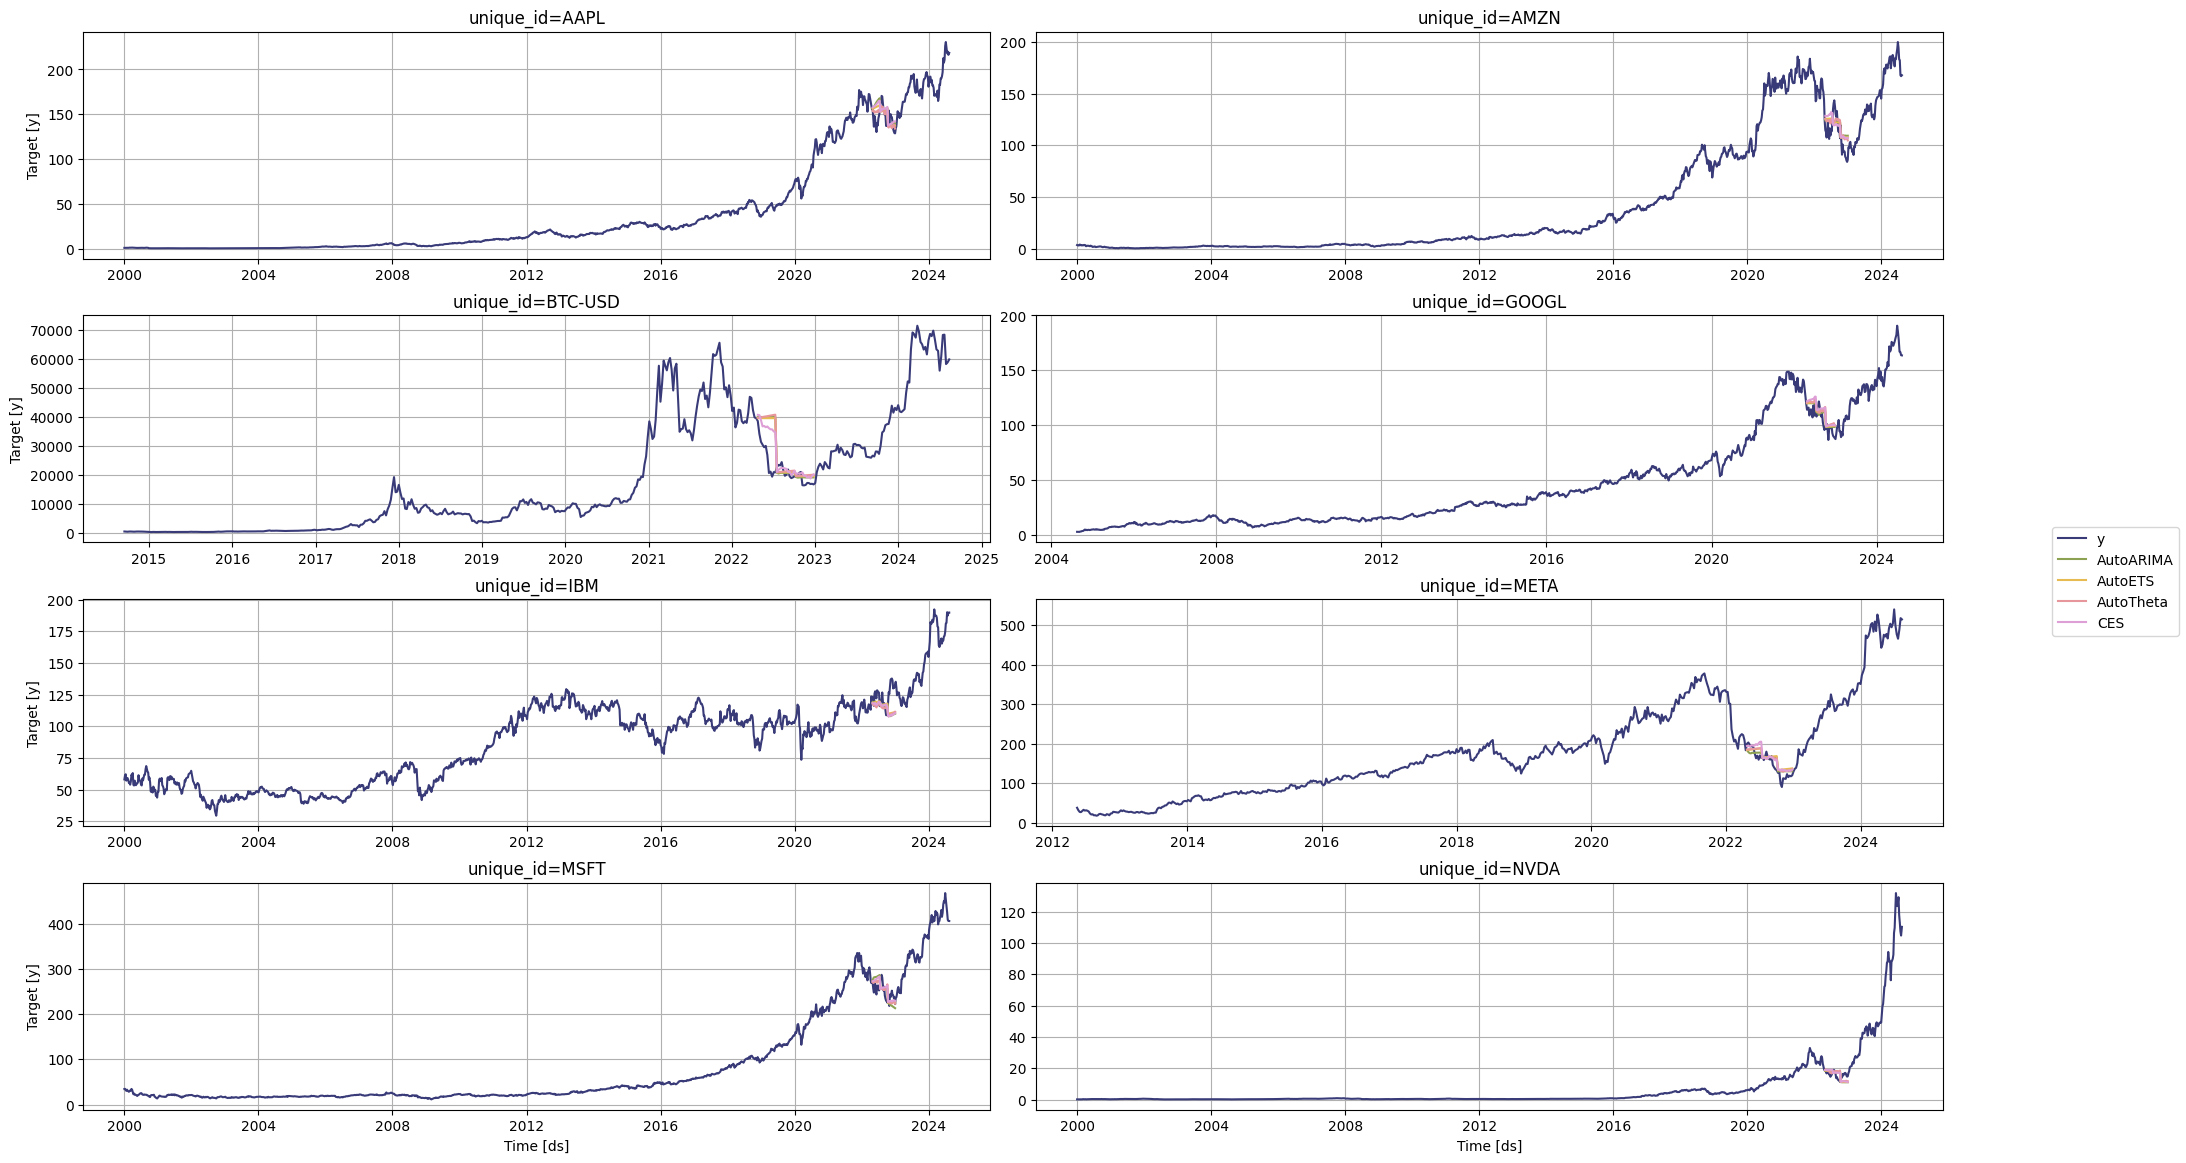

In [8]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))